In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
train_data = torchvision.datasets.CIFAR10(root='./data/', train=True, download=True,
                                        transform=transforms.ToTensor())

test_data = torchvision.datasets.CIFAR10(root='./data/', train=False, download=True,
                                        transform=transforms.ToTensor())

train_data, val_data = torch.utils.data.random_split(train_data, [40000, 10000])

100%|██████████████████████████████████████████████████████████████| 170498071/170498071 [00:15<00:00, 10774538.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [4]:
image, answer = train_data[0]

In [5]:
image.shape

torch.Size([3, 32, 32])

In [6]:
answer

3

In [7]:
batch_size = 100

In [18]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size,
                                           shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [19]:
import matplotlib.pyplot as plt

%matplotlib inline

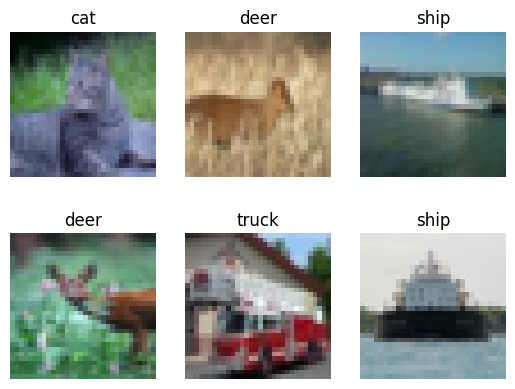

In [20]:
examples = iter(train_loader)
example_data, example_target = next(examples)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i].squeeze().permute(1, 2, 0))
    plt.title(classes[example_target[i].item()])
    plt.axis('off')

In [21]:
import torch.nn as nn

In [22]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FullyConnectedNN, self).__init__()
        
        self.input_size = input_size
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        bs = x.shape[0]
        y = x.reshape(bs, -1)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        
        return y

In [23]:
model = FullyConnectedNN(input_size=3*32*32, hidden_size=500, num_classes=10)

In [24]:
from torch.optim import Adam

In [25]:
loss = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=0.001)

In [26]:
%%time

best_val = 0
best_model = None
steps_without_improvement = 0

epoch = 0
while steps_without_improvement <= 5:
    for i, (images, target) in enumerate(train_loader):
        opt.zero_grad()
        
        outputs = model(images)
        err = loss(outputs, target)
        
        err.backward()
        opt.step()
        
        if (i + 1) % 100 == 0:
            print('Epoch ' + str(epoch) + ', Step [' + str(i + 1) + '/' + \
                  str(len(train_loader)) + ']' + ', Loss: ' + str(err.item()))
    
    
    with torch.no_grad():
        n_images = 0
        correct_images = 0
        for i, (images, target) in enumerate(val_loader):
            pred = model(images).max(-1).indices
            
            n_images += images.shape[0]
            correct_images += (pred == target).sum()
            
        val_res = correct_images / n_images
        
        print('\n==== Validation ====')
        print('Accuracy', val_res.item())
        print('====================')
        
        if val_res > best_val:
            best_val = val_res
            best_model = model.state_dict().copy()
            steps_without_improvement = 0
        else:
            steps_without_improvement += 1
            
    epoch += 1

Epoch 0, Step [100/400], Loss: 1.9959825277328491
Epoch 0, Step [200/400], Loss: 1.8813667297363281
Epoch 0, Step [300/400], Loss: 1.8247910737991333
Epoch 0, Step [400/400], Loss: 1.7654826641082764

==== Validation ====
Accuracy 0.35370001196861267
Epoch 1, Step [100/400], Loss: 1.7917377948760986
Epoch 1, Step [200/400], Loss: 1.7920007705688477
Epoch 1, Step [300/400], Loss: 1.7870820760726929
Epoch 1, Step [400/400], Loss: 1.81841242313385

==== Validation ====
Accuracy 0.36340001225471497
Epoch 2, Step [100/400], Loss: 1.6008378267288208
Epoch 2, Step [200/400], Loss: 1.3902878761291504
Epoch 2, Step [300/400], Loss: 1.7398202419281006
Epoch 2, Step [400/400], Loss: 1.7102484703063965

==== Validation ====
Accuracy 0.40450000762939453
Epoch 3, Step [100/400], Loss: 1.6395771503448486
Epoch 3, Step [200/400], Loss: 1.750787615776062
Epoch 3, Step [300/400], Loss: 1.5134440660476685
Epoch 3, Step [400/400], Loss: 1.576439619064331

==== Validation ====
Accuracy 0.420199990272522
Ep

In [27]:
model.load_state_dict(best_model)

with torch.no_grad():
    n_images = 0
    correct_images = 0
    for images, targets in test_loader:
        outputs = model(images)
        
        predicted_classes = outputs.max(-1).indices
        n_images += images.shape[0]
        correct_images += (predicted_classes == targets).sum()
        
print(correct_images / n_images)

tensor(0.4889)
